In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [3]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 1.7 MB/s eta 0:00:00a 0:00:01


In [4]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [5]:
import paddle
from paddle.vision.transforms import Compose, Normalize
import math

# 数据集的构建

## 加载mnist数据集 

In [6]:
batch_size=256


# 使用transform对数据集做归一化
transform = Compose([Normalize(mean=[0],
                               std=[255],
                               data_format='CHW')])

# 训练数据集
train_datasets = paddle.vision.datasets.MNIST(mode='train',transform=transform)

# 测试数据集
test_datasets = paddle.vision.datasets.MNIST(mode='test',transform=transform)

print('训练集样本量: {}，验证集样本量: {}'.format(len(train_datasets), len(test_datasets)))


item  162/2421 [=>............................] - ETA: 1s - 752us/item

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download


item 8/8 [============================>.] - ETA: 0s - 2ms/item


Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download

Download finished


item 207/403 [==============>...............] - ETA: 0s - 707us/item

Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download


item 2/2 [===========================>..] - ETA: 0s - 1ms/item  


Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download

Download finished


训练集样本量: 60000，验证集样本量: 10000


In [8]:
train_datasets[0][0].shape

(1, 28, 28)

## 图像进行加噪

In [11]:
import numpy as np
#1、将数据格式进行转换
x_train = [i[0] for i in train_datasets]
x_test = [i[0] for i in test_datasets]

x_train = np.reshape(x_train,(len(x_train),1,28,28))
x_test = np.reshape(x_test,(len(x_test),1,28,28))
print('训练数据的长度是{} 测试数据的长度是{}'.format(len(x_train),len(x_test)))
print('训练数据的shape是{} 测试数据的shape是{}'.format(x_train[0].shape,x_test[0].shape))


#2、添加随机白噪声（均值是0，方差为1）
noise_factor = 0.5
x_train_noise = x_train+noise_factor*np.random.normal(loc=0.0,scale=1.0,size=x_train.shape)
x_test_noise = x_test+noise_factor*np.random.normal(loc=0.0,scale=1.0,size=x_test.shape)
#限制加完噪声的数值取值范围
x_train_noise = np.clip(x_train_noise,0,1) 
x_test_noise = np.clip(x_test_noise,0,1)

print('添加噪声后数据长度是{} 测试数据的长度是{}'.format(len(x_train_noise),len(x_test_noise)))
print('添加噪声后数据的shape是{} 测试数据的shape是{}'.format(x_train_noise[0].shape,x_test_noise[0].shape))

训练数据的长度是60000 测试数据的长度是10000
训练数据的shape是(1, 28, 28) 测试数据的shape是(1, 28, 28)
添加噪声后数据长度是60000 测试数据的长度是10000
添加噪声后数据的shape是(1, 28, 28) 测试数据的shape是(1, 28, 28)


## 构建dataset，输入为噪声图片，标签为原图

In [12]:
import paddle
import json
import gzip
import numpy as np

# 创建一个类MnistDataset，继承paddle.io.Dataset 这个类
class MnistDataset(paddle.io.Dataset):
    def __init__(self, mode):
        super(MnistDataset, self).__init__()
        # 读取到的数据区分训练集，验证集，测试集
        if mode == 'train':
            # 获得训练数据集
            imgs, labels = x_train_noise, x_train
        elif mode == 'test':
            # 获得测试数据集
            imgs, labels = x_test_noise,x_test
        else:
            raise Exception("mode can only be one of ['train', 'valid', 'eval']")

        # 校验数据
        imgs_length = len(imgs)
        assert len(imgs) == len(labels), \
            "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))

        self.imgs = imgs  
        self.labels = labels

    def __getitem__(self, idx):
        img = np.array(self.imgs[idx]).astype('float32') 
        label = np.array(self.labels[idx]).astype('float32')

        return img, label

    def __len__(self):
        return len(self.imgs)


## 数据可视化

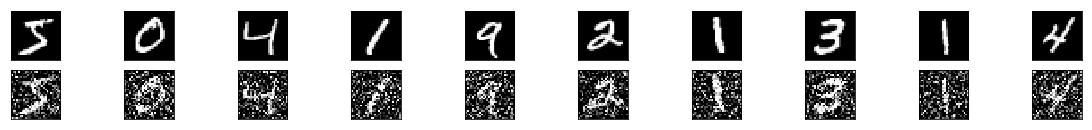

In [15]:
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

n = 10 

plt.figure(figsize=(20,2)) 
for i in range(n): 
    ax = plt.subplot(2,n,i+1) 
    plt.imshow(x_train[i][0].reshape(28,28)) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)

for i in range(n): 
    ax = plt.subplot(2,n,10+i+1) 
    plt.imshow(x_train_noise[i][0].reshape(28,28)) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)

plt.show()



## 构建dataloader

In [18]:
train_dataset = MnistDataset(mode='train')
train_loader = paddle.io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 模型的构建：构建自编码器，此处采用动态图

In [16]:
import paddle
import paddle.nn.functional as F

class autoencoder(paddle.nn.Layer):
    def __init__(self):
        super(autoencoder, self).__init__()
        # encoder部分
        # （1， 28， 28） ---> （32， 28， 28）
        self.conv1 = paddle.nn.Conv2D(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding=1)
        # （32， 28， 28）--- > (32, 14, 14)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        # （32， 14,  14)--- > (64, 14, 14)
        self.conv2 = paddle.nn.Conv2D(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1,padding=1)
        #  (64, 14, 14)--- > (64, 7, 7)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        
        # decoder部分
        # (64, 7, 7) ----> 
        self.conv3 = paddle.nn.Conv2D(in_channels=64, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.up_pool3 = paddle.nn.Upsample(size=[14,14]) #不改变channel，只是将其hw翻倍
        self.conv4 = paddle.nn.Conv2D(in_channels=64, out_channels=32, kernel_size=(3,3), stride=1,padding=1)
        self.up_pool4 = paddle.nn.Upsample(size=[28,28])
        self.conv5 = paddle.nn.Conv2D(in_channels=32, out_channels=1, kernel_size=(3,3), stride=1, padding=1)
        
        
    def forward(self, x):
        # encoder部分
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        #decoder部分
        x = self.conv3(x)
        x = F.relu(x)
        x = self.up_pool3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.up_pool4(x)
        x = self.conv5(x)
        x = F.sigmoid(x)
        return x

In [17]:
model = autoencoder()
#查看模型结构
params_info = paddle.summary(model, (1, 1, 28, 28))
print(params_info)

W0504 16:52:56.556185   163 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0504 16:52:56.559684   163 device_context.cc:465] device: 0, cuDNN Version: 8.2.


---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1       [[1, 1, 28, 28]]     [1, 32, 28, 28]          320      
  MaxPool2D-1    [[1, 32, 28, 28]]     [1, 32, 14, 14]           0       
   Conv2D-2      [[1, 32, 14, 14]]     [1, 64, 14, 14]        18,496     
  MaxPool2D-2    [[1, 64, 14, 14]]      [1, 64, 7, 7]            0       
   Conv2D-3       [[1, 64, 7, 7]]       [1, 64, 7, 7]         36,928     
  Upsample-1      [[1, 64, 7, 7]]      [1, 64, 14, 14]           0       
   Conv2D-4      [[1, 64, 14, 14]]     [1, 32, 14, 14]        18,464     
  Upsample-2     [[1, 32, 14, 14]]     [1, 32, 28, 28]           0       
   Conv2D-5      [[1, 32, 28, 28]]      [1, 1, 28, 28]          289      
Total params: 74,497
Trainable params: 74,497
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

# 构建优化器

In [19]:
optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())

# 训练

In [22]:
def train(model, optim, epochs): 
    model.train()
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader,1):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            # y_data为0， 1可以采用二分类交叉熵损失按数
            loss = F.binary_cross_entropy(predicts, y_data) 
                # 计算损失
            loss.backward()
            optim.step()
            optim.clear_grad()

            if batch_id % 50 == 0:
                opt_lr = optim.get_lr()
                print("epoch: {}, batch_id: {}, loss is: {}, opt_lr: {}".format(epoch, batch_id, loss.numpy(), opt_lr))


In [23]:
epochs = 20
train(model, optim, epochs)

epoch: 0, batch_id: 50, loss is: [0.1508055], opt_lr: 0.001
epoch: 0, batch_id: 100, loss is: [0.13356395], opt_lr: 0.001
epoch: 0, batch_id: 150, loss is: [0.12579954], opt_lr: 0.001
epoch: 0, batch_id: 200, loss is: [0.11945431], opt_lr: 0.001
epoch: 1, batch_id: 50, loss is: [0.11757692], opt_lr: 0.001
epoch: 1, batch_id: 100, loss is: [0.11732341], opt_lr: 0.001
epoch: 1, batch_id: 150, loss is: [0.11405985], opt_lr: 0.001
epoch: 1, batch_id: 200, loss is: [0.11205357], opt_lr: 0.001
epoch: 2, batch_id: 50, loss is: [0.10728515], opt_lr: 0.001
epoch: 2, batch_id: 100, loss is: [0.10778838], opt_lr: 0.001
epoch: 2, batch_id: 150, loss is: [0.10553826], opt_lr: 0.001
epoch: 2, batch_id: 200, loss is: [0.10809629], opt_lr: 0.001
epoch: 3, batch_id: 50, loss is: [0.10743915], opt_lr: 0.001
epoch: 3, batch_id: 100, loss is: [0.10226806], opt_lr: 0.001
epoch: 3, batch_id: 150, loss is: [0.1021505], opt_lr: 0.001
epoch: 3, batch_id: 200, loss is: [0.10333781], opt_lr: 0.001
epoch: 4, batc

# 预测

In [24]:
test_dataset = MnistDataset(mode='test')
# 使用paddle.io.DataLoader 定义DataLoader对象用于加载Python生成器产生的数据，
test_loader = paddle.io.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [51]:
 for batch_id, data in enumerate(test_loader):
    x_data = data[0]
    y_data = data[1]
    predicts = model(x_data)
    break

## 可视化原图与网络去噪后图像

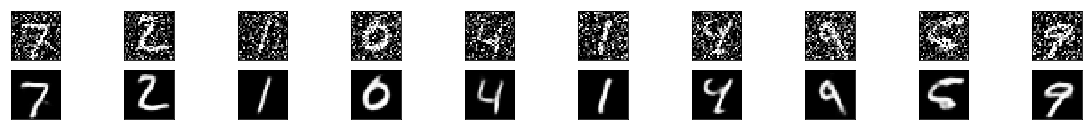

In [52]:
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

n = 10 

x_data = x_data.numpy()
predicts = predicts.numpy()

plt.figure(figsize=(20,2)) 
for i in range(n): 
    ax = plt.subplot(2,n,i+1) 
    plt.imshow(x_data[i][0].reshape(28,28)) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)

for i in range(n): 
    ax = plt.subplot(2,n,10+i+1) 
    plt.imshow(predicts[i].reshape(28,28)) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)

plt.show()



# 使用 paddle.jit.to_static 实现动转静

## 改写组网代码

In [42]:
class autoencoder2(paddle.nn.Layer):
    def __init__(self):
        super(autoencoder2, self).__init__()
        # encoder部分
        # （1， 28， 28） ---> （32， 28， 28）
        self.conv1 = paddle.nn.Conv2D(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding=1)
        # （32， 28， 28）--- > (32, 14, 14)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        # （32， 14,  14)--- > (64, 14, 14)
        self.conv2 = paddle.nn.Conv2D(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1,padding=1)
        #  (64, 14, 14)--- > (64, 7, 7)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        
        # decoder部分
        # (64, 7, 7) ----> 
        self.conv3 = paddle.nn.Conv2D(in_channels=64, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.up_pool3 = paddle.nn.Upsample(size=[14,14]) #不改变channel，只是将其hw翻倍
        self.conv4 = paddle.nn.Conv2D(in_channels=64, out_channels=32, kernel_size=(3,3), stride=1,padding=1)
        self.up_pool4 = paddle.nn.Upsample(size=[28,28])
        self.conv5 = paddle.nn.Conv2D(in_channels=32, out_channels=1, kernel_size=(3,3), stride=1, padding=1)
        
    
    # 在forward 前添加 paddle.jit.to_static 装饰器
    @paddle.jit.to_static()
    def forward(self, x):
        # encoder部分
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        #decoder部分
        x = self.conv3(x)
        x = F.relu(x)
        x = self.up_pool3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.up_pool4(x)
        x = self.conv5(x)
        x = F.sigmoid(x)
        return x

## 模型训练

In [43]:
epochs = 20
model_2 = autoencoder2()
optim_2 = paddle.optimizer.Adam(learning_rate=0.001, parameters=model_2.parameters())
train(model_2, optim_2, epochs)

epoch: 0, batch_id: 50, loss is: [0.169617], opt_lr: 0.001
epoch: 0, batch_id: 100, loss is: [0.14395738], opt_lr: 0.001
epoch: 0, batch_id: 150, loss is: [0.1290719], opt_lr: 0.001
epoch: 0, batch_id: 200, loss is: [0.12327737], opt_lr: 0.001
epoch: 1, batch_id: 50, loss is: [0.11703932], opt_lr: 0.001
epoch: 1, batch_id: 100, loss is: [0.11644541], opt_lr: 0.001
epoch: 1, batch_id: 150, loss is: [0.11610189], opt_lr: 0.001
epoch: 1, batch_id: 200, loss is: [0.11325552], opt_lr: 0.001
epoch: 2, batch_id: 50, loss is: [0.11371018], opt_lr: 0.001
epoch: 2, batch_id: 100, loss is: [0.10730042], opt_lr: 0.001
epoch: 2, batch_id: 150, loss is: [0.10588661], opt_lr: 0.001
epoch: 2, batch_id: 200, loss is: [0.10843735], opt_lr: 0.001
epoch: 3, batch_id: 50, loss is: [0.10706727], opt_lr: 0.001
epoch: 3, batch_id: 100, loss is: [0.10239325], opt_lr: 0.001
epoch: 3, batch_id: 150, loss is: [0.10862175], opt_lr: 0.001
epoch: 3, batch_id: 200, loss is: [0.10543257], opt_lr: 0.001
epoch: 4, batch

## 使用 paddle.jit.save 保存动转静模型

In [44]:
paddle.jit.save(model_2, 'model')

Wed May 04 17:28:16 Dynamic-to-Static WARNING: Current function: forward(x), input_spec: None has more than one cached programs: 2, the last traced progam will be return by default.


## 使用 paddle.jit.load 加载动转静模型

In [45]:
model_2 = paddle.jit.load('model')

## 预测

In [49]:
 for batch_id, data in enumerate(test_loader):
    x_data = data[0]
    y_data = data[1]
    predicts = model_2(x_data)
    break

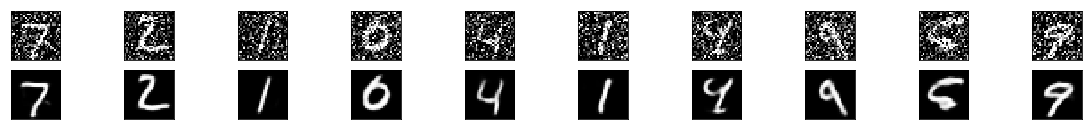

In [50]:
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

n = 10 

x_data = x_data.numpy()
predicts = predicts.numpy()

plt.figure(figsize=(20,2)) 
for i in range(n): 
    ax = plt.subplot(2,n,i+1) 
    plt.imshow(x_data[i][0].reshape(28,28)) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)

for i in range(n): 
    ax = plt.subplot(2,n,10+i+1) 
    plt.imshow(predicts[i].reshape(28,28)) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)

plt.show()



请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 